In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import snn_classifier as snn_clas

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [3]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [4]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['animal', 'nature', 'human', 'domestic', 'urban']

In [5]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    if target < 10:
        dataset.loc[index, 'h_category'] = 0
    elif target < 20:
        dataset.loc[index, 'h_category'] = 1
    elif target < 30:
        dataset.loc[index, 'h_category'] = 2
    elif target < 40:
        dataset.loc[index, 'h_category'] = 3
    elif target < 50:
        dataset.loc[index, 'h_category'] = 4

In [6]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,3
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,3
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [7]:
c_data = pd.concat([ps.preprocess_fold(fld, dataset) for fld in range(1,6)], ignore_index=True)

In [8]:
c_data['h_category'] = 4
c_data.loc[c_data['target'] < 40, 'h_category'] = 3
c_data.loc[c_data['target'] < 30, 'h_category'] = 2
c_data.loc[c_data['target'] < 20, 'h_category'] = 1
c_data.loc[c_data['target'] < 10, 'h_category'] = 0

In [9]:
c_data.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,target,h_category
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0,0
1,83.621621,-50.483010,-31.115186,-3.566867,-19.398316,-14.354486,-4.658161,-14.146847,-16.949019,-1.723476,...,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0,0
2,109.848331,-110.083820,-54.568920,-30.153585,-58.985460,-5.598281,-5.862913,17.490401,12.544187,13.053928,...,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0,0
3,77.698670,-123.925469,-64.058169,-27.170063,-57.606930,-9.980594,6.718248,21.293678,15.173490,-1.113725,...,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0,0
4,58.790968,-133.719666,-76.282456,-25.140746,-54.371150,-13.053846,14.737484,17.361937,12.619366,-8.285872,...,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,0,0


In [10]:
c_data, scalar = du.normalize_data(c_data, 'h_category')

In [11]:
train, test = du.split_training_test(c_data, 0.2)
train_X = train.drop(columns=['target', 'h_category'])
train_y = train.h_category
test_X = test.drop(columns=['target', 'h_category'])
test_y = test.h_category

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

def multiclass_shallow_net():
    # Create Model
    model = Sequential()
    model.add(Dense(38, activation='relu', input_shape=(38,)))
    model.add(Dropout(0.2))
    model.add(Dense(5, kernel_initializer='normal', activation='softmax'))
    
    model.summary()
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam')
    return model

In [13]:
clas = KerasClassifier(build_fn=multiclass_shallow_net, epochs=20, batch_size=128, verbose=1)
clas.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 38)                1482      
_________________________________________________________________
dropout_1 (Dropout)          (None, 38)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 195       
Total params: 1,677
Trainable params: 1,677
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
310994/310994 [==============================] - 18s 57us/step - loss: 1.3879
Epoch 2/20
310994/310994 [==============================] - 12s 38us/step - loss: 1.3054
Epoch 3/20
310994/310994 [==============================] - 11s 37us/step - loss: 1.2846
Epoch 4/20
310994/310994 [==============================] - 11s 37us/step - loss: 1.2740
Epoch 5/20
310994/310994 [======================

77749/77749 [==============================] - 1s 10us/step
0.5078393291232042
Confusion matrix, without normalization
[[ 7469  2089  1848  1004  2961]
 [  805  8571  1521  1945  3782]
 [ 1889  2377  6128  2416  1697]
 [  785  3209  1992  5928  2664]
 [ 1193  1810  1028  1250 11388]]


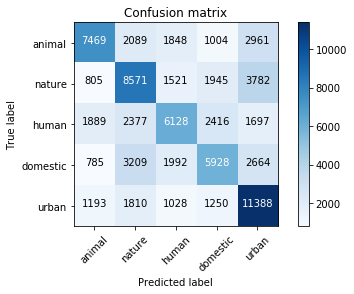

In [14]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plot_confusion_matrix(cm, h_classes)
plt.show()